## Notebook set up

**Your task**: Apply at least two different feature engineering techniques to the `housing_df` dataframe to improve the dataset. At the end of the notebook, your engineered dataset and the original dataset will be used to train a linear regression model to predict `MedHouseVal`. Your goal is to achieve better model performance via feature engineering.

**Note**: If you have read ahead or you are familiar with the basics of training ML models, no there is no train-test split and yes, this means data leakage/genralizability is a concern. We will cover those topics in the next unit. For now, the goal is to keep things simple while still giving you an idea of how your feature engineering effects model performance.

Before applying transformations, explore the dataset to understand what techniques would be most beneficial.

### Import libraries

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
# Set random seed for reproducibility
np.random.seed(315)

### Load dataset

In [2]:
# Load California housing dataset
original_housing_df = pd.read_csv('https://gperdrizet.github.io/FSA_devops/assets/data/unit2/california_housing.csv')
housing_df = original_housing_df.copy()

## Task 1: Explore the dataset

Before deciding what feature engineering techniques to apply, explore the dataset to understand its characteristics.

**Things to investigate**:
- Display basic information about the dataset (`.info()`, `.describe()`)
- Check for missing values
- Examine feature distributions (histograms, box plots)
- Look at feature scales and ranges

Use this exploration to inform your feature engineering decisions in the following tasks.

In [3]:
housing_df.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [4]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [5]:
housing_df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [6]:
housing_df.isna().sum()

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

In [7]:
def logit(x):
    return np.log1p(x)

In [8]:
def plot_hist_and_log(df, count_cols, bins=50, include_log=False):
    """
    For each column in count_cols, plot:
      1) Regular histogram with mean, median, and mode lines (all red)
      2) log1p-transformed histogram (handling zeros/negatives with a shift),
         also with mean, median, and mode lines (all red) if include_log is True.
    Saves both plots as PNGs.
    """
    for c in count_cols:
        # Drop NaNs and ensure float
        x = np.asarray(df[c].dropna(), dtype=float)
        if x.size == 0:
            print(f"Column {c} has no non-NaN values, skipping.")
            continue

        # --- Statistics for original data ---
        mean_val = np.mean(x)
        median_val = np.median(x)
        mode_series = pd.Series(x).mode()
        mode_val = mode_series.iloc[0] if not mode_series.empty else None

        # --- Regular histogram ---
        fig, ax = plt.subplots()
        ax.hist(x, bins=bins)

        # Vertical lines for mean, median, mode (all red)
        ax.axvline(mean_val,   color="red", linestyle="--", label=f"Mean: {mean_val:.2f}")
        ax.axvline(median_val, color="red", linestyle="-.", label=f"Median: {median_val:.2f}")
        if mode_val is not None:
            ax.axvline(mode_val, color="red", linestyle=":", label=f"Mode: {mode_val:.2f}")

        ax.set_title(f"Histogram: {c}")
        ax.set_xlabel(c)
        ax.set_ylabel("Count")
        ax.legend()
        plt.show()

        if not include_log:
            continue

        # --- Log1p histogram (with shift so we can take log) ---
        x_log = logit(x)

        # Stats in log space
        mean_log = np.mean(x_log)
        median_log = np.median(x_log)
        mode_log_series = pd.Series(x_log).mode()
        mode_log = mode_log_series.iloc[0] if not mode_log_series.empty else None

        fig, ax = plt.subplots()
        ax.hist(x_log, bins=bins)

        ax.axvline(mean_log,   color="red", linestyle="--", label=f"Mean (log): {mean_log:.2f}")
        ax.axvline(median_log, color="red", linestyle="-.", label=f"Median (log): {median_log:.2f}")
        if mode_log is not None:
            ax.axvline(mode_log, color="red", linestyle=":", label=f"Mode (log): {mode_log:.2f}")

        ax.set_title(f"Histogram (log1p): {c}")
        ax.set_xlabel(f"log1p({c})")
        ax.set_ylabel("Count")
        ax.legend()
        plt.show()


In [9]:

housing_df["PopDensity"] = housing_df["Population"] / (
    (housing_df["Latitude"] - housing_df["Latitude"].mean())**2 +
    (housing_df["Longitude"] - housing_df["Longitude"].mean())**2 + 1
)

In [10]:
numeric_cols = [
    "MedInc", "HouseAge", "AveRooms", "AveBedrms",
    "Population", "AveOccup", "Latitude", "Longitude",
    "MedHouseVal", "BedroomsPerOccupant", "RoomsPerOccupant",
    "BedrmsPerRoom", "RoomsPerPerson", "PopPerHousehold", "DistToCoast", 
    "DistToCoast2", "LatLon","LatDivLon", "PopDensity"
]

num_cols = housing_df.select_dtypes(include=["number"]).columns


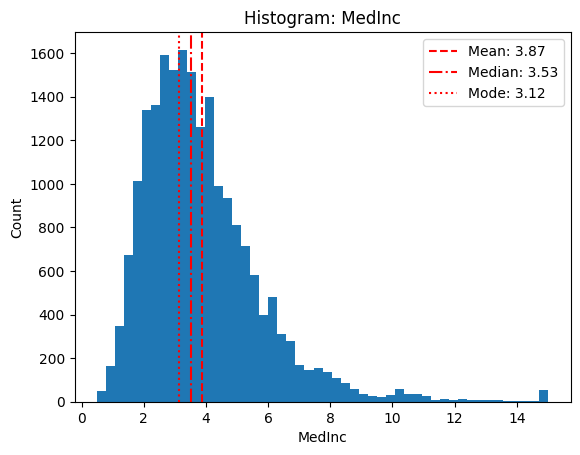

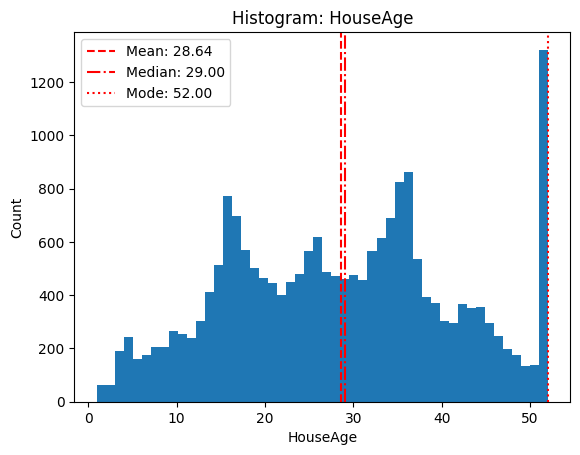

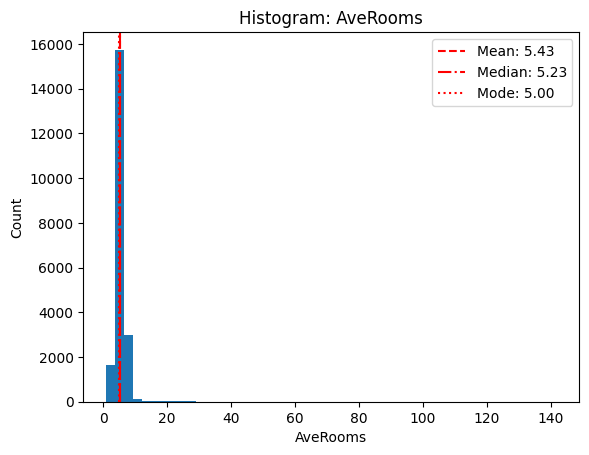

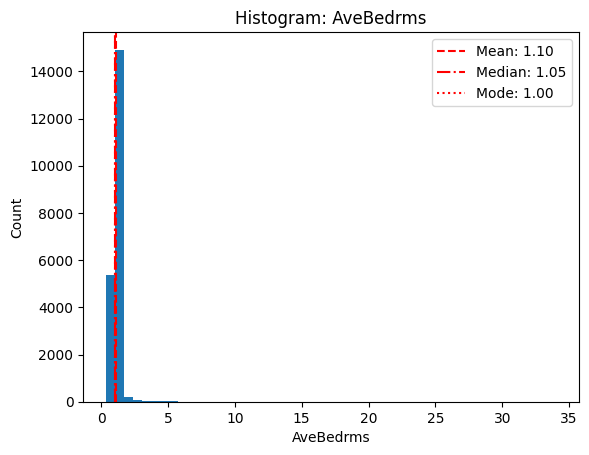

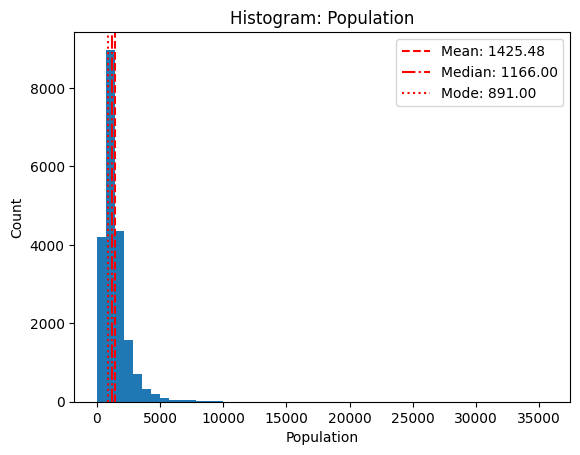

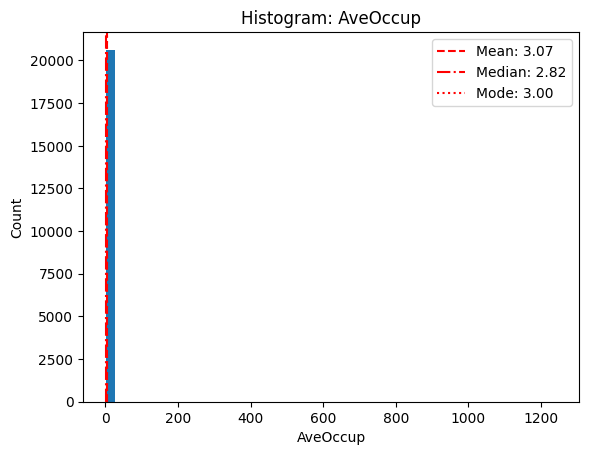

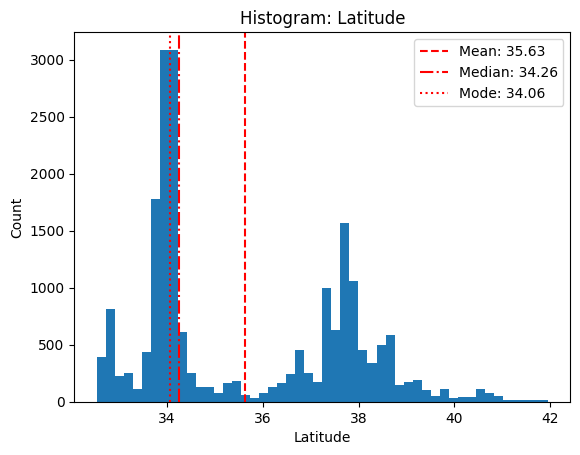

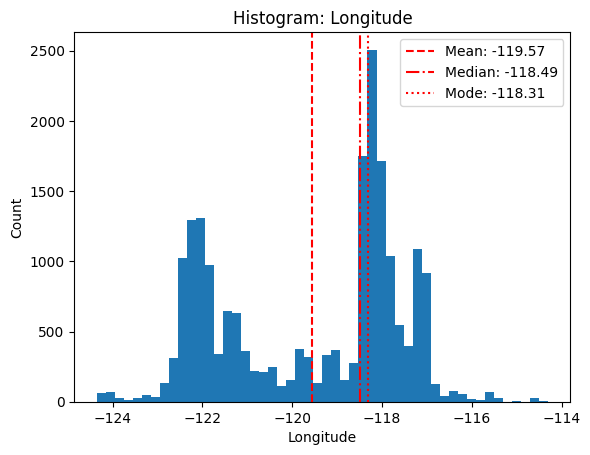

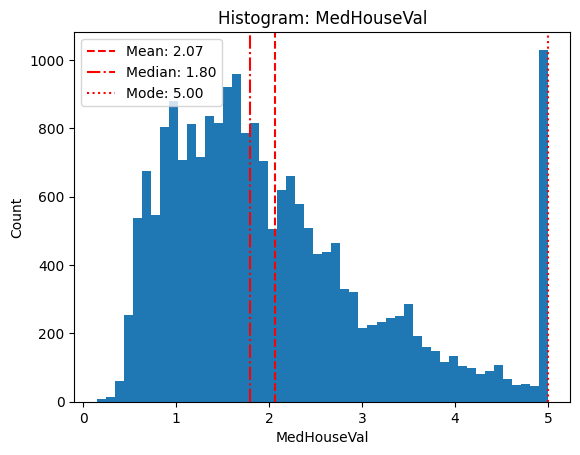

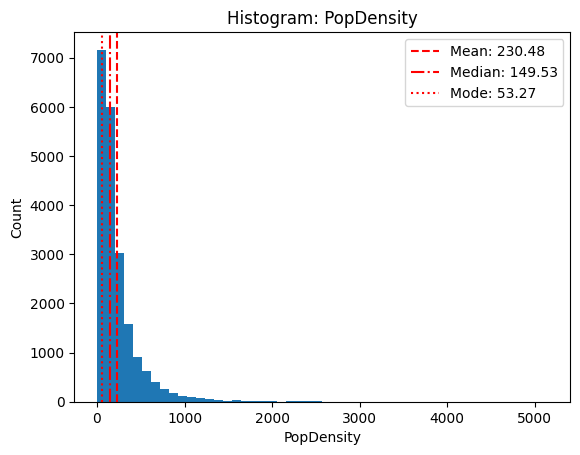

In [11]:
plot_hist_and_log(housing_df, num_cols,include_log =False)

In [12]:
housing_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
 9   PopDensity   20640 non-null  float64
dtypes: float64(10)
memory usage: 1.6 MB


## Task 2: Apply your first feature engineering technique

Based on your exploration, apply your first feature engineering technique.

**Example approaches**:
- Transform skewed features using log, sqrt, power, or quantile transformations
- Create bins/categories from continuous variables
- Create interaction features (e.g., rooms per household = total rooms / households)

In [13]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
 9   PopDensity   20640 non-null  float64
dtypes: float64(10)
memory usage: 1.6 MB


In [14]:
housing_df["BedrmsPerRoom"] = housing_df["AveBedrms"] / housing_df["AveRooms"] # 2% impact



In [15]:
housing_df["LatLon"] = housing_df["Latitude"] * housing_df["Longitude"] #1% impact


## Task 3: Apply your second feature engineering technique

**Example approaches**:
- Scale features to similar ranges
- Encode any categorical variables you created
- Create aggregate statistics by groups

In [16]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
housing_df["AveRooms_pt"] = pt.fit_transform(housing_df[["AveRooms"]]) # 1% impact
housing_df["AveOccup_pt"] = pt.fit_transform(housing_df[["AveOccup"]]) # 7% impact
housing_df["MedHouseVal_pt"] = pt.fit_transform(housing_df[["MedHouseVal"]]) # 60% impact



In [17]:
housing_df["AveOccup"].describe()

housing_df["AveOccup"].quantile([0.95, 0.99, 0.995, 0.999])


0.950     4.333417
0.990     5.394812
0.995     6.122155
0.999    13.630443
Name: AveOccup, dtype: float64

In [18]:
# Choose a high percentile so you only drop the truly extreme weirdos
cutoff = housing_df["AveOccup"].quantile(0.990)

print("AveOccup cutoff:", cutoff)

housing_trimmed = housing_df[housing_df["AveOccup"] <= cutoff].copy()
print("Original rows:", len(housing_df))
print("Trimmed rows:", len(housing_trimmed))


AveOccup cutoff: 5.394812032520327
Original rows: 20640
Trimmed rows: 20433


In [19]:
housing_df = housing_df[housing_df["AveOccup"] <= 5.394812032520327].copy()


## (Optional) Additional feature engineering

Add more techniques if you'd like to experiment further.

In [20]:
housing_df["IsMaxAge"] = (housing_df["HouseAge"] >= 52).astype(int) # 1% impact



In [21]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution="uniform") #2% impact
housing_df["Lat_uniform"] = qt.fit_transform(housing_df[["Latitude"]])
housing_df["Lon_uniform"] = qt.fit_transform(housing_df[["Longitude"]])

# If we drop `Lon_uniform` and keep `Lat_uniform` it goes down 3%
#If we keep `Lon_uniform` and drop `Lat_uniform` it goes up 4%
#If we keep both it goes up 3%
#if we drop both it goes down 2%
#housing_df = housing_df.drop(["Lon_uniform"], axis=1) 
housing_df = housing_df.drop(["Lat_uniform"], axis=1) # If we keep this one it goes down 



In [22]:
housing_df.info()
housing_df["HouseAge"].isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 20433 entries, 0 to 20639
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   MedInc          20433 non-null  float64
 1   HouseAge        20433 non-null  float64
 2   AveRooms        20433 non-null  float64
 3   AveBedrms       20433 non-null  float64
 4   Population      20433 non-null  float64
 5   AveOccup        20433 non-null  float64
 6   Latitude        20433 non-null  float64
 7   Longitude       20433 non-null  float64
 8   MedHouseVal     20433 non-null  float64
 9   PopDensity      20433 non-null  float64
 10  BedrmsPerRoom   20433 non-null  float64
 11  LatLon          20433 non-null  float64
 12  AveRooms_pt     20433 non-null  float64
 13  AveOccup_pt     20433 non-null  float64
 14  MedHouseVal_pt  20433 non-null  float64
 15  IsMaxAge        20433 non-null  int64  
 16  Lon_uniform     20433 non-null  float64
dtypes: float64(16), int64(1)
memory usag

np.int64(0)

In [23]:
#transformer = QuantileTransformer(output_distribution='uniform')
transformer = QuantileTransformer(output_distribution='normal')

#housing_df[f'LatLon_quantile_normal'] = transformer.fit_transform(housing_df[["LatLon"]])
housing_df[f'HouseAge_quantile_normal'] = transformer.fit_transform(housing_df[["HouseAge"]])


## Model evaluation

Now we'll compare model performance on the original dataset versus your engineered dataset.

### Evaluate datasets

In [24]:
# Create output directory if it doesn't exist
output_directory = 'data/outputs'
Path(output_directory).mkdir(parents=True, exist_ok=True)

# Save a copy of the engineered dataframe
housing_df.to_csv('data/outputs/housing_df.csv', index=False)

In [25]:
# Create linear regression model
model = LinearRegression()

# Evaluate on original dataset
scores_original = cross_val_score(
    model,
    original_housing_df.drop('MedHouseVal', axis=1),
    original_housing_df['MedHouseVal'],
    cv=10,
    scoring='r2'
)

# Evaluate on engineered dataset
scores_engineered = cross_val_score(
    model,
    housing_df.drop('MedHouseVal', axis=1),
    housing_df['MedHouseVal'],
    cv=10,
    scoring='r2'
)

engineered_mean = scores_engineered.mean()
original_mean = scores_original.mean()
mean_improvement = (engineered_mean - original_mean) / original_mean

print(f'\nMean improvement: {mean_improvement:.2f}%')


Mean improvement: 0.80%


### Visualize model performance comparison

/tmp/ipykernel_1468217/2694266218.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[0].boxplot(data_to_plot, labels=labels)


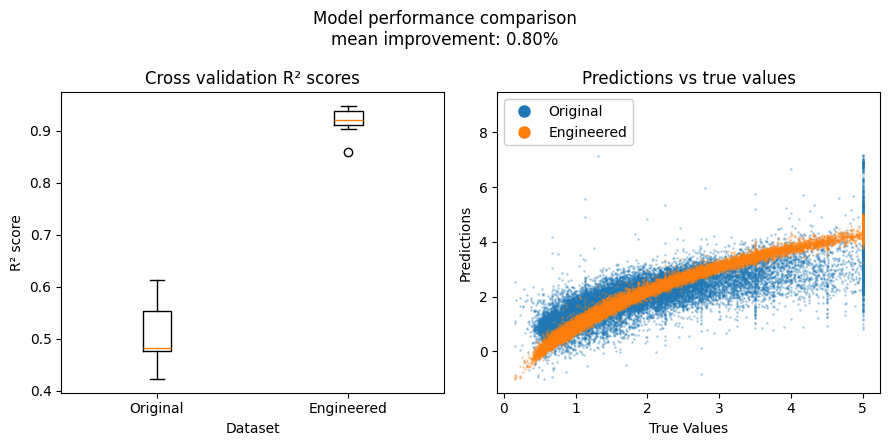

In [26]:
original_model = LinearRegression()
original_model.fit(original_housing_df.drop('MedHouseVal', axis=1), original_housing_df['MedHouseVal'])
original_predictions = original_model.predict(original_housing_df.drop('MedHouseVal', axis=1))

model = LinearRegression()
model.fit(housing_df.drop('MedHouseVal', axis=1), housing_df['MedHouseVal'])
predictions = model.predict(housing_df.drop('MedHouseVal', axis=1))

# Create boxplot comparing performance
data_to_plot = [scores_original, scores_engineered]
labels = ['Original', 'Engineered']

fig, axs = plt.subplots(1, 2, figsize=(9,4.5))

fig.suptitle(f'Model performance comparison\nmean improvement: {mean_improvement:.2f}%')

axs[0].set_title('Cross validation R² scores')
axs[0].boxplot(data_to_plot, labels=labels)
axs[0].set_xlabel('Dataset')
axs[0].set_ylabel('R² score')

axs[1].set_title('Predictions vs true values')
axs[1].plot(
    original_housing_df['MedHouseVal'], original_predictions,
    'o', markersize=1, label='Original', alpha=0.25
)

axs[1].plot(
    housing_df['MedHouseVal'], predictions,
    'o', markersize=1, label='Engineered', alpha=0.25
)

axs[1].set_xlabel('True Values')
axs[1].set_ylabel('Predictions')

leg = axs[1].legend(loc='upper left', markerscale=8, framealpha=1)

for lh in leg.legend_handles: 
    lh.set_alpha(1)

plt.tight_layout()
plt.show()

## 3. Reflection

**Questions to consider**:

1. Which feature engineering techniques had the biggest impact on model performance?
2. Did adding more features always improve performance, or did some hurt it?
3. How might you further improve the engineered dataset?
4. What trade-offs did you consider (e.g., interpretability vs performance, complexity vs gains)?

**Your reflection**:

So the biggest problem with the data was the outliers. You have just a few housing records that have high occupency and must be either really gigantic homes or multiplexes. 

There were two thing that helped the most and that was PowerTransformer on `AveRoom` and `AveOccup`. When I dove it that I realized there was some major outliers. PowerTransformer realy does help normalize outliers. The other approach was to get rid of the outliers because the seem like they are multiplexes. Getting rid of them after all having the data rangled, did give the final push. 